# Data Loading and Preprocessing

In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import holidays
import plotly.express as px
import datetime
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
tf.random.set_seed(42)

In [133]:
df = pd.read_csv('/kaggle/input/padma-bridge-toll-dataset/Padma_Bridge - Traffic.csv',parse_dates=['Date'], dayfirst=True)
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y %H:%M:%S')
df.sort_values('Date', inplace=True)
df.reset_index(drop=True, inplace=True)

In [134]:
df['Total_Cash'] = (
    df['Total_Cash']
    .astype(str)                
    .str.replace(',', '')      
    .str.strip()                
)

df['Total_Cash'] = pd.to_numeric(df['Total_Cash'], errors='coerce')

df['Total_Cash'] = df['Total_Cash'].fillna(df['Cash_Mawa'] + df['Cash_Jajira'])

In [135]:
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['isWeekend'] =  df['Date'].dt.weekday.isin([4,5]).astype(int)

df['DayOfWeek'] = df['Date'].dt.dayofweek
df['DayOfYear'] = df['Date'].dt.dayofyear
df['WeekOfYear'] = df['Date'].dt.isocalendar().week
df['Quarter'] = df['Date'].dt.quarter

In [136]:
bd_holidays = holidays.Bangladesh(years=df['Year'].unique())
official_holidays = set(bd_holidays.keys())

extra_holidays = {
    datetime.date(2025, 8, 5),
    datetime.date(2024, 8, 5)
}

all_holidays = official_holidays.union(extra_holidays)

df['isHoliday'] = df['Date'].dt.date.isin(all_holidays).astype(int)

In [137]:
df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)
df['Day_sin'] = np.sin(2 * np.pi * df['Day'] / 31)
df['Day_cos'] = np.cos(2 * np.pi * df['Day'] / 31)
df['DayOfWeek_sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
df['DayOfWeek_cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)
df['Weekend_Holiday'] = df['isWeekend'] * df['isHoliday']
df['Holiday_Month'] = df['isHoliday'] * df['Month']

In [138]:
target_cols = ['Traffic_Mawa','Traffic_Jajira','Cash_Mawa','Cash_Jajira', 'Total_Cash', 'Total_Traffic']

In [139]:
lags=[1, 7, 14, 30]
    
for col in target_cols:
    for lag in lags:
        df[f'{col}_lag_{lag}'] = df[col].shift(lag)

In [140]:
windows=[7, 14, 30]

for col in target_cols:
    for window in windows:
        df[f'{col}_rolling_mean_{window}'] = df[col].rolling(window=window).mean()
        df[f'{col}_rolling_std_{window}'] = df[col].rolling(window=window).std()
        df[f'{col}_rolling_min_{window}'] = df[col].rolling(window=window).min()
        df[f'{col}_rolling_max_{window}'] = df[col].rolling(window=window).max()
        
        # Exponential weighted mean
        df[f'{col}_ewm_mean_{window}'] = df[col].ewm(span=window).mean()

In [141]:
print(f"Features created. Shape before dropping NaN: {df.shape}")

df = df.dropna()

print(f"Shape after dropping NaN: {df.shape}")

Features created. Shape before dropping NaN: (1170, 138)
Shape after dropping NaN: (1140, 138)


In [142]:
exclude_cols = target_cols + ['Date']
feature_cols = [col for col in df.columns if col not in exclude_cols]

X = df[feature_cols]
y = df[target_cols]

In [143]:
tsa_main = TimeSeriesSplit(n_splits=5)
train_idx, test_idx = list(tsa_main.split(X))[-1] 

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

print(f"\nTraining set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")
print(f"Training date range: {df.iloc[train_idx]['Date'].min()} to {df.iloc[train_idx]['Date'].max()}")
print(f"Test date range: {df.iloc[test_idx]['Date'].min()} to {df.iloc[test_idx]['Date'].max()}")


Training set: 950 samples
Test set: 190 samples
Training date range: 2022-06-07 00:00:00 to 2025-03-07 00:00:00
Test date range: 2025-03-08 00:00:00 to 2025-12-08 00:00:00


In [144]:
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data)-seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

In [145]:
units_list = [32, 64, 128]
dropout_list = [0.1, 0.2, 0.3]
lr_list = [0.001, 0.005]
batch_list = [16, 32]

In [146]:
scaled_data = scaler_y.fit_transform(df[target_cols].values)
X_seq, y_seq = create_sequences(scaled_data, SEQ_LENGTH)

In [147]:
split = int(0.8*len(X_seq))
X_train_seq, X_test_seq = X_seq[:split], X_seq[split:]
y_train_seq, y_test_seq = y_seq[:split], y_seq[split:]

In [148]:
def build_lstm_model(input_shape, units=50, dropout=0.2, lr=0.001):
    model = Sequential()
    model.add(LSTM(units, input_shape=input_shape, return_sequences=False))
    model.add(Dropout(dropout))
    model.add(Dense(y_train.shape[1]))  
    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

In [149]:
pip install optuna

Note: you may need to restart the kernel to use updated packages.


# HP Tuning using Optuna

In [150]:
import optuna
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    nonzero_idx = y_true != 0
    return np.mean(np.abs((y_true[nonzero_idx] - y_pred[nonzero_idx]) / y_true[nonzero_idx])) * 100

def objective(trial):
    units = trial.suggest_categorical('units', [32, 64, 128])
    dropout = trial.suggest_float('dropout', 0.1, 0.3)
    lr = trial.suggest_float('lr', 0.001, 0.01, log=True)
    batch_size = trial.suggest_categorical('batch_size', [8, 16, 32, 64])

    model = Sequential()
    model.add(LSTM(units, input_shape=(SEQ_LENGTH, X_train_seq.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(y_train_seq.shape[1]))  # multi-target
    model.compile(optimizer=Adam(learning_rate=lr), loss='mse', metrics=['mae'])
    
    early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True)
    
    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=100,
        batch_size=batch_size,
        validation_split=0.1,
        callbacks=[early_stop],
        verbose=0
    )

    y_pred = model.predict(X_test_seq)
    y_pred_rescaled = scaler_y.inverse_transform(y_pred)
    y_test_rescaled = scaler_y.inverse_transform(y_test_seq)

    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    
    return mae 

In [151]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)  

[I 2025-10-15 08:04:43,407] A new study created in memory with name: no-name-9549ede2-92b7-4947-9633-bcea58aa8e09


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


[I 2025-10-15 08:04:48,788] Trial 0 finished with value: 1042021.7915870791 and parameters: {'units': 64, 'dropout': 0.10868286296376475, 'lr': 0.0063722746175591495, 'batch_size': 16}. Best is trial 0 with value: 1042021.7915870791.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


[I 2025-10-15 08:04:52,042] Trial 1 finished with value: 999187.7861765499 and parameters: {'units': 32, 'dropout': 0.11039506975177252, 'lr': 0.004785906165636838, 'batch_size': 64}. Best is trial 1 with value: 999187.7861765499.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


[I 2025-10-15 08:04:55,296] Trial 2 finished with value: 1077924.1058688394 and parameters: {'units': 64, 'dropout': 0.29959115636951983, 'lr': 0.0016310348981078305, 'batch_size': 64}. Best is trial 1 with value: 999187.7861765499.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


[I 2025-10-15 08:04:58,670] Trial 3 finished with value: 1027386.3792224497 and parameters: {'units': 64, 'dropout': 0.1319548715446836, 'lr': 0.0030734899527693504, 'batch_size': 64}. Best is trial 1 with value: 999187.7861765499.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


[I 2025-10-15 08:05:03,308] Trial 4 finished with value: 990143.5758632038 and parameters: {'units': 32, 'dropout': 0.212715140377014, 'lr': 0.001873135477902537, 'batch_size': 32}. Best is trial 4 with value: 990143.5758632038.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


[I 2025-10-15 08:05:12,100] Trial 5 finished with value: 1023274.6958531229 and parameters: {'units': 128, 'dropout': 0.22047075369454516, 'lr': 0.004009369136916977, 'batch_size': 8}. Best is trial 4 with value: 990143.5758632038.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


[I 2025-10-15 08:05:16,321] Trial 6 finished with value: 970906.2799027454 and parameters: {'units': 32, 'dropout': 0.21691065597077236, 'lr': 0.004146039969870549, 'batch_size': 32}. Best is trial 6 with value: 970906.2799027454.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


[I 2025-10-15 08:05:20,534] Trial 7 finished with value: 1128699.9863661265 and parameters: {'units': 128, 'dropout': 0.2750232260725938, 'lr': 0.00226103650633599, 'batch_size': 16}. Best is trial 6 with value: 970906.2799027454.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


[I 2025-10-15 08:05:26,205] Trial 8 finished with value: 1029960.4952498338 and parameters: {'units': 32, 'dropout': 0.25879397532463155, 'lr': 0.005483305529836897, 'batch_size': 8}. Best is trial 6 with value: 970906.2799027454.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


[I 2025-10-15 08:05:30,658] Trial 9 finished with value: 1003314.235819409 and parameters: {'units': 32, 'dropout': 0.1199195178398169, 'lr': 0.005863176179662656, 'batch_size': 64}. Best is trial 6 with value: 970906.2799027454.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


[I 2025-10-15 08:05:33,979] Trial 10 finished with value: 1164190.49044876 and parameters: {'units': 32, 'dropout': 0.16847851719303142, 'lr': 0.0010403838448282054, 'batch_size': 32}. Best is trial 6 with value: 970906.2799027454.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


[I 2025-10-15 08:05:37,621] Trial 11 finished with value: 1000111.0542146344 and parameters: {'units': 32, 'dropout': 0.1982634909055764, 'lr': 0.0022868314107118474, 'batch_size': 32}. Best is trial 6 with value: 970906.2799027454.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


[I 2025-10-15 08:05:41,092] Trial 12 finished with value: 1167149.9470365415 and parameters: {'units': 32, 'dropout': 0.2222854510812026, 'lr': 0.0015027333811961344, 'batch_size': 32}. Best is trial 6 with value: 970906.2799027454.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


[I 2025-10-15 08:05:45,128] Trial 13 finished with value: 1011345.2583323297 and parameters: {'units': 32, 'dropout': 0.17561542590211468, 'lr': 0.009888575556652299, 'batch_size': 32}. Best is trial 6 with value: 970906.2799027454.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


[I 2025-10-15 08:05:50,523] Trial 14 finished with value: 993958.465125892 and parameters: {'units': 32, 'dropout': 0.23993588819801662, 'lr': 0.003042164694325993, 'batch_size': 32}. Best is trial 6 with value: 970906.2799027454.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


[I 2025-10-15 08:05:55,484] Trial 15 finished with value: 1024481.5583367032 and parameters: {'units': 128, 'dropout': 0.18576837853434805, 'lr': 0.0021014622516515617, 'batch_size': 32}. Best is trial 6 with value: 970906.2799027454.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


[I 2025-10-15 08:05:58,820] Trial 16 finished with value: 1159585.0364712395 and parameters: {'units': 32, 'dropout': 0.15870687955050625, 'lr': 0.0010336995023151642, 'batch_size': 32}. Best is trial 6 with value: 970906.2799027454.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


[I 2025-10-15 08:06:04,155] Trial 17 finished with value: 994654.9636083483 and parameters: {'units': 32, 'dropout': 0.2205905207713189, 'lr': 0.007895719001358282, 'batch_size': 32}. Best is trial 6 with value: 970906.2799027454.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


[I 2025-10-15 08:06:08,124] Trial 18 finished with value: 996286.1259478823 and parameters: {'units': 128, 'dropout': 0.14404202947163142, 'lr': 0.003992886013422588, 'batch_size': 16}. Best is trial 6 with value: 970906.2799027454.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


[I 2025-10-15 08:06:15,261] Trial 19 finished with value: 982291.5952048056 and parameters: {'units': 64, 'dropout': 0.2538378809855625, 'lr': 0.0017887156711819667, 'batch_size': 8}. Best is trial 6 with value: 970906.2799027454.


In [152]:
best_params = study.best_params
best_model = Sequential()
best_model.add(LSTM(best_params['units'], input_shape=(SEQ_LENGTH, X_train_seq.shape[2])))
best_model.add(Dropout(best_params['dropout']))
best_model.add(Dense(y_train_seq.shape[1]))
best_model.compile(optimizer=Adam(learning_rate=best_params['lr']), loss='mse', metrics=['mae'])

In [153]:
history = best_model.fit(
    X_train_seq, y_train_seq,
    epochs=100,
    batch_size=best_params['batch_size'],
    validation_split=0.1,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
    verbose=0
)

In [154]:
print("Best MAE:", best_mae)
print("Best Params:", best_params)

Best MAE: 972894.8328325044
Best Params: {'units': 32, 'dropout': 0.21691065597077236, 'lr': 0.004146039969870549, 'batch_size': 32}


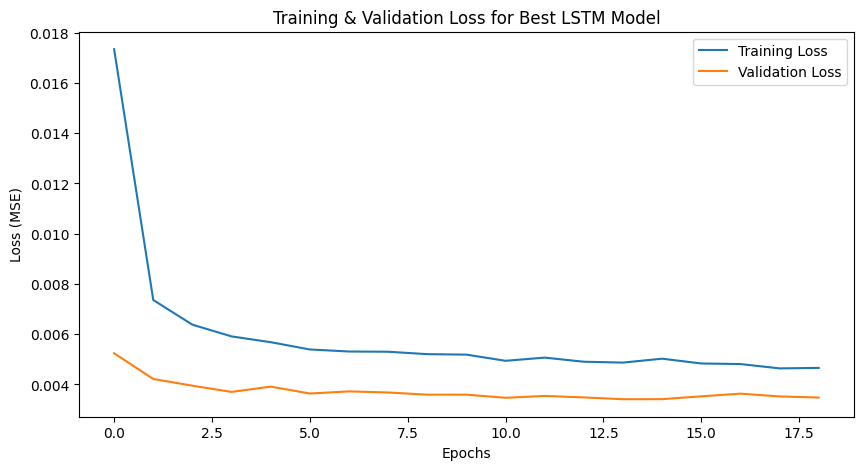

In [156]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training & Validation Loss for Best LSTM Model')
plt.legend()
plt.show()

In [157]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

y_pred = best_model.predict(X_test_seq)
y_pred_rescaled = scaler_y.inverse_transform(y_pred)
y_test_rescaled = scaler_y.inverse_transform(y_test_seq)

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    nonzero_idx = y_true != 0
    return np.mean(np.abs((y_true[nonzero_idx] - y_pred[nonzero_idx]) / y_true[nonzero_idx])) * 100

mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_rescaled, y_pred_rescaled)
mape = mean_absolute_percentage_error(y_test_rescaled, y_pred_rescaled)

print(f"Overall MAE: {mae:.2f}")
print(f"Overall MSE: {mse:.2f}")
print(f"Overall RMSE: {rmse:.2f}")
print(f"Overall R²: {r2:.3f}")
print(f"Overall MAPE: {mape:.2f}%")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Overall MAE: 1011869.10
Overall MSE: 5996118722285.44
Overall RMSE: 2448697.35
Overall R²: -0.035
Overall MAPE: 12.81%


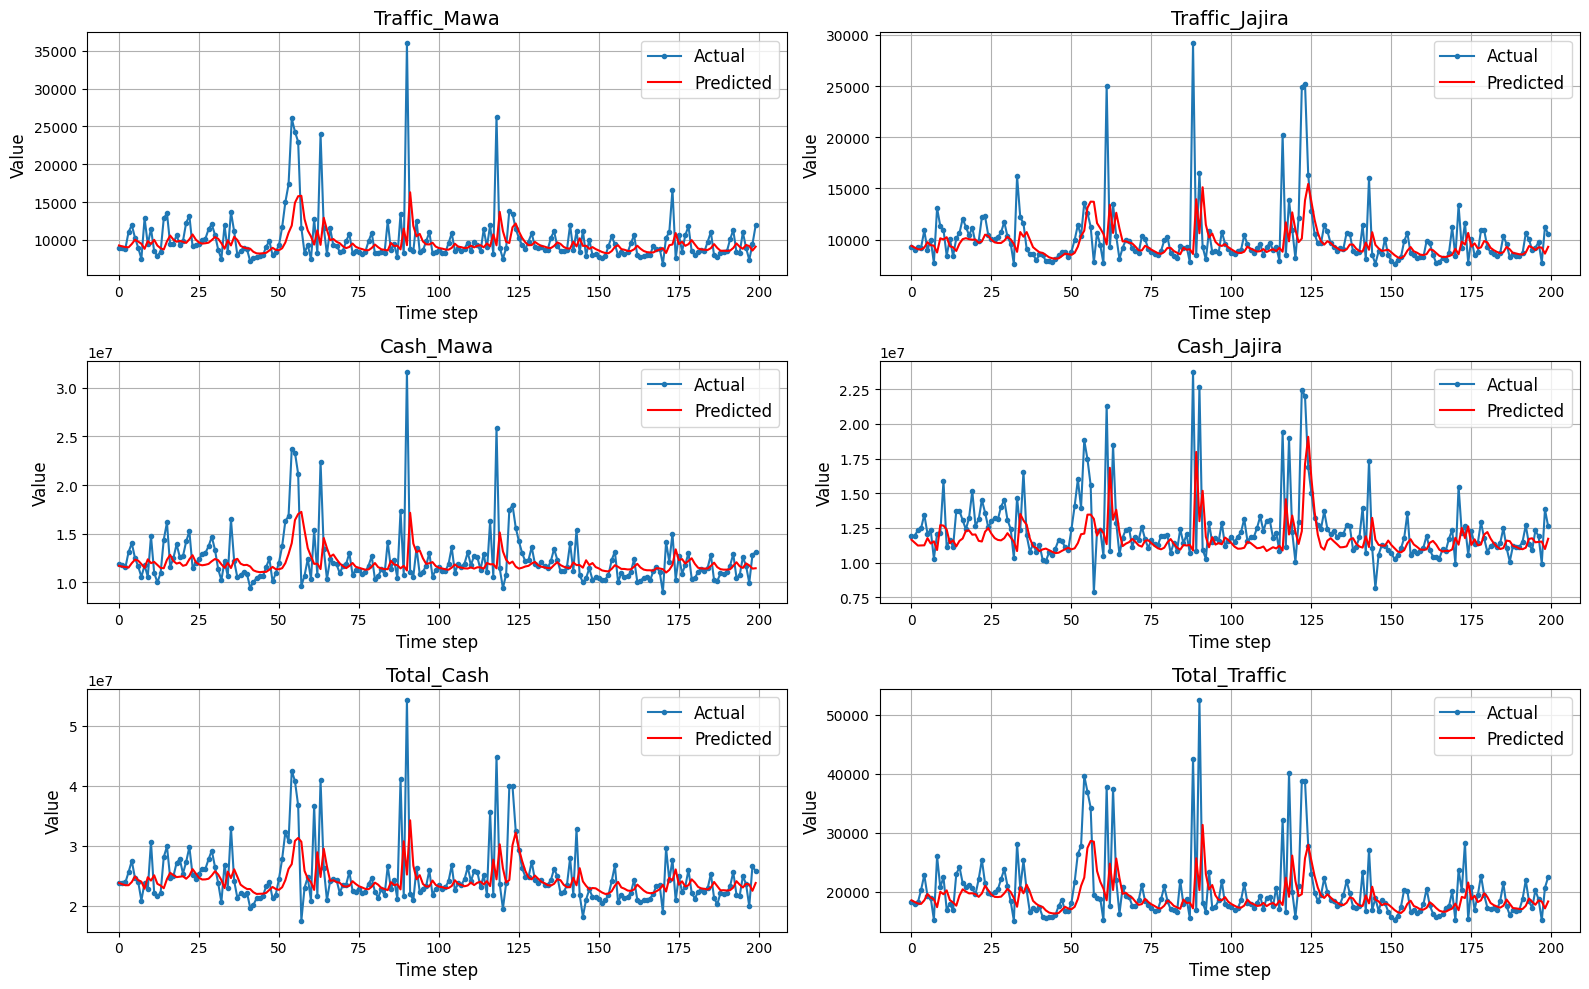

In [158]:
import matplotlib.pyplot as plt

steps = 200
time_steps = [x for x in range(steps)]

plt.figure(figsize=(16, 10))

for i, col in enumerate(target_cols):
    plt.subplot(3, 2, i+1)
    plt.plot(time_steps, y_test_rescaled[:steps, i], marker='.', label='Actual')
    plt.plot(time_steps, y_pred_rescaled[:steps, i], 'r', label='Predicted')
    plt.title(col, fontsize=14)
    plt.xlabel('Time step', fontsize=12)
    plt.ylabel('Value', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True)

plt.tight_layout()
plt.show()

In [159]:
N_DAYS = 365

In [160]:
def forecast_next_days(model, last_sequence, n_days, scaler):
    predictions = []
    current_seq = last_sequence.copy()
    
    for _ in range(n_days):
        pred = model.predict(current_seq[np.newaxis, :, :], verbose=0)[0]
        predictions.append(pred)
        current_seq = np.vstack([current_seq[1:], pred])

    predictions = scaler.inverse_transform(np.array(predictions))
    return predictions

In [161]:
last_seq = scaled_targets[-SEQ_LENGTH:]  
forecast_result = forecast_next_days(best_model, last_seq, N_DAYS, scaler_y)

In [162]:
forecast_dates = pd.date_range(start=df['Date'].iloc[-1] + pd.Timedelta(days=1), periods=N_DAYS)
forecast_df = pd.DataFrame(forecast_result, columns=target_cols)
forecast_df['Date'] = forecast_dates

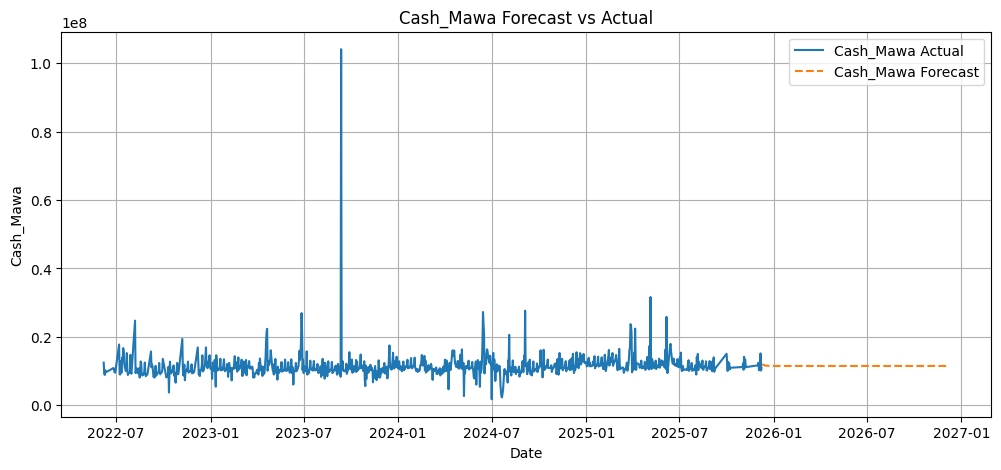

In [163]:
plt.figure(figsize=(12,5))
plt.plot(df['Date'], df['Cash_Mawa'], label='Cash_Mawa Actual')
plt.plot(forecast_df['Date'], forecast_df['Cash_Mawa'], label='Cash_Mawa Forecast', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Cash_Mawa')
plt.title('Cash_Mawa Forecast vs Actual')
plt.legend()
plt.grid(True)
plt.show()

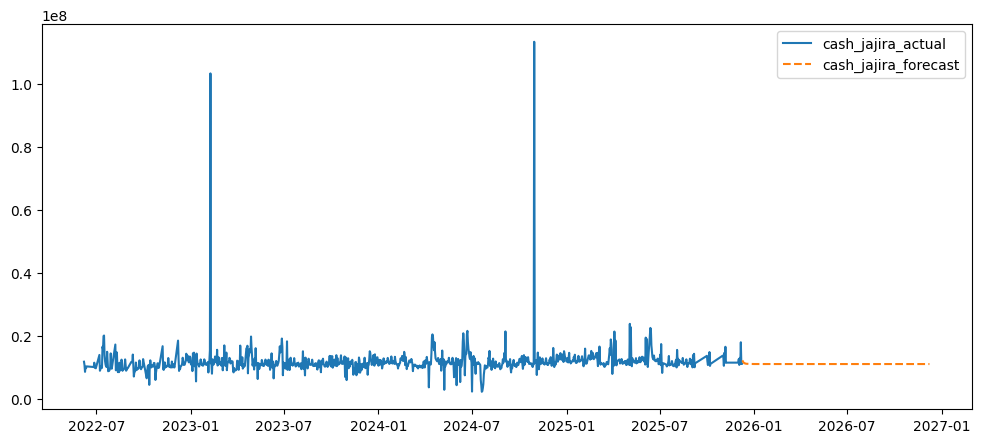

In [164]:
plt.figure(figsize=(12,5))
plt.plot(df['Date'], df['Cash_Jajira'], label='cash_jajira_actual')
plt.plot(forecast_df['Date'], forecast_df['Cash_Jajira'], label='cash_jajira_forecast', linestyle='--')
plt.legend()
plt.show()

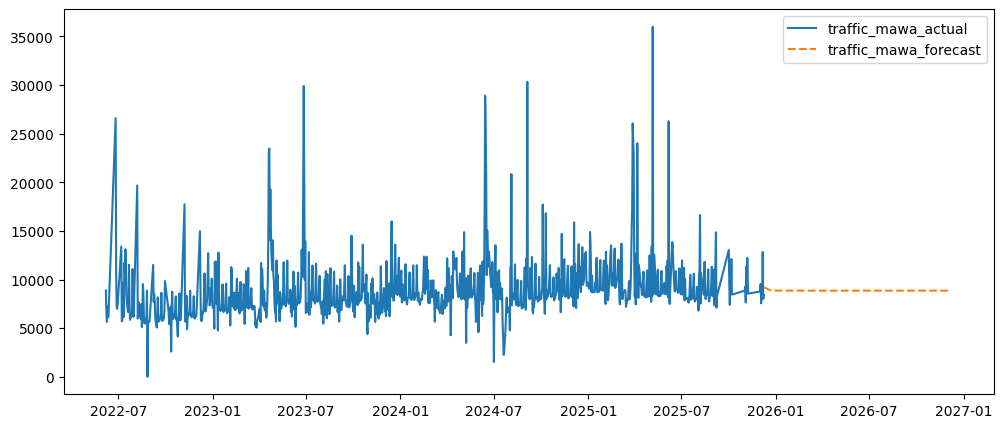

In [165]:
plt.figure(figsize=(12,5))
plt.plot(df['Date'], df['Traffic_Mawa'], label='traffic_mawa_actual')
plt.plot(forecast_df['Date'], forecast_df['Traffic_Mawa'], label='traffic_mawa_forecast', linestyle='--')
plt.legend()
plt.show()

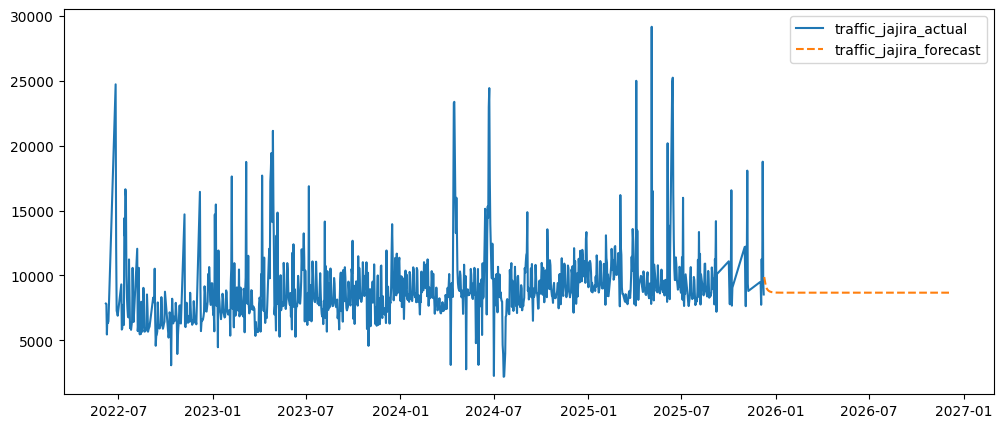

In [166]:
plt.figure(figsize=(12,5))
plt.plot(df['Date'], df['Traffic_Jajira'], label='traffic_jajira_actual')
plt.plot(forecast_df['Date'], forecast_df['Traffic_Jajira'], label='traffic_jajira_forecast', linestyle='--')
plt.legend()
plt.show()